In [30]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.optimize
from scipy.optimize import root
from scipy.optimize import fsolve

## SN Curve Prediction - Reverse Engineering

### Data Generation from an SN Curve

In [2]:
def S_e(a,b, S_uts, S_100):
    a = a/100
    b = b/100
    S_a  = 0.5*(b - a)*S_100
    S_m  = 0.5*(b + a)*S_100
    S_e  = S_a/(1-S_m/S_uts)
    
    return S_e

In [32]:
m = 4.52
k = 6.89e15

S_100 = 250
S_uts = 340

In [35]:
S_e_array = np.array([])
N_array = np.array([])

a_arr = ([40, 70, 33, 40, 33.33, 58.33])
b_arr = ([100, 100, 83, 80, 66.66, 83.33])


for i in range(6):
    Se = S_e(a_arr[i], b_arr[i],S_uts, S_100)
    N_life = k/(Se**m)
    S_e_array = np.append(S_e_array, Se )
    N_array = np.append(N_array, N_life )
    

# print(S_e_array)
# print(N_array)
# print(N_array*S_e_array**m)

[  878385.24954548  6283754.68316223  4261017.14667669 10388584.4266574
 41440177.25555827 43390730.02755097]


### Reverse Engineering the process to estimate S_uts (Ultimate Tensile Strength)

In [12]:
S_100 = 250

a_ar = ([40, 70, 40, 33, 33])
b_ar = ([100, 100, 80, 66, 83])

N = [878385,  6283754,  4261017, 10388584, 41440177, 43390730]


In [ ]:
S_uts_arr = np.array([])

for i in range(4):
    a_new = np.delete(a_ar,i)
    b_new = np.delete(b_ar,i)
    N_new = np.delete(N, i)
    
    Sa_new = 0.5*(b_new/100 - a_new/100)*S_100
    Sm_new = 0.5*(b_new/100 + a_new/100)*S_100
    
    c1 = np.around( np.log(N_new[1]/N_new[0])/np.log(N_new[2]/N_new[0]) , decimals = 4)

    c2 = np.around( (Sa_new[2]**c1)/(Sa_new[1]*Sa_new[0]**(c1-1)) , decimals = 4)

    c3 = np.around( (Sm_new[2]**c1)/(Sm_new[1]*Sm_new[0]**(c1-1)) , decimals = 4)

    r = root(lambda d: (d/Sm_new[2] -1)**c1 - (c2/c3)*(d/Sm_new[1] -1)*(d/Sm_new[0] -1)**(c1-1), S_100)
    
    S_uts_arr = np.append(r.x[0],S_uts_arr)

    
S_uts_est = np.mean(S_uts_arr)

In [13]:
print(S_uts_est)

340.1205897465577


### Reverse Engineering the process to estimate m (slope of sn curve)

In [14]:
S_100 = 250

# S_uts = S_uts_est

a_ar = ([40, 70, 33, 40, 33.33, 58.33])
b_ar = ([100, 100, 83, 80, 66.66, 83.33])

N  = [878385.24954548,  6283754.68316223, 10388584.4266574,  44485645.30313765]

In [15]:
m_est_ar = np.array([])

for i in range(4):
    
    Se1 = S_e(a_ar[i], b_ar[i], S_uts_est, S_100)
    N1 = N[i]
    
    for j in range(i+1,4,1):
        
            Se2 = S_e(a_ar[j], b_ar[j], S_uts_est, S_100)
            N2 = N[j]
            
            m_temp = (np.log(N2/N1))/(np.log(Se1/Se2))
            
            m_est_ar = np.append(m_est_ar, m_temp)
            
m_est = np.round( np.mean(m_est_ar),2)      

In [16]:
print(m_est)

4.52


### Reverse Engineering the process to estimate k in NS^m = k

In [17]:
S_100 = 250

# S_uts = S_uts_est

a_ar = ([40, 70, 40, 33, 33, 58])
b_ar = ([100, 100, 80, 66, 83, 83])

N  = [878385.24954548,  6283754.68316223, 10388584.4266574,  44485645.30313765]

In [18]:
k_est_arr = np.array([])

for i in range(4):
    Se = S_e(a_ar[i], b_ar[i], S_uts_est, S_100)
    k_temp = N[i]*(Se**m_est)
    
    k_est_arr = np.append(k_est_arr, k_temp)

k_est = np.mean(k_est_arr)

In [19]:
print(k_est)

6878725738273665.0


### Analysing the behaviour of different cycles with S_uts

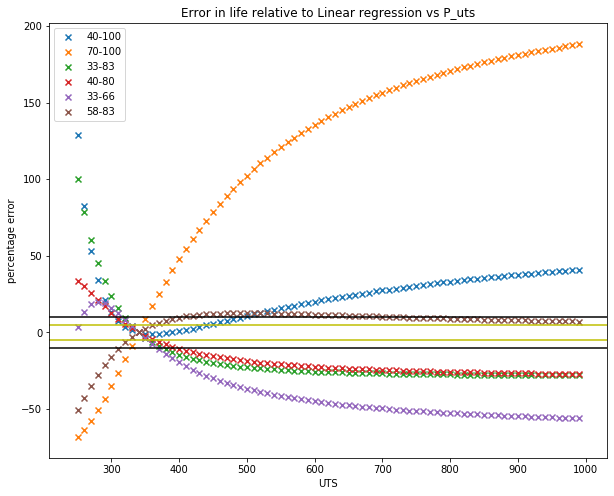

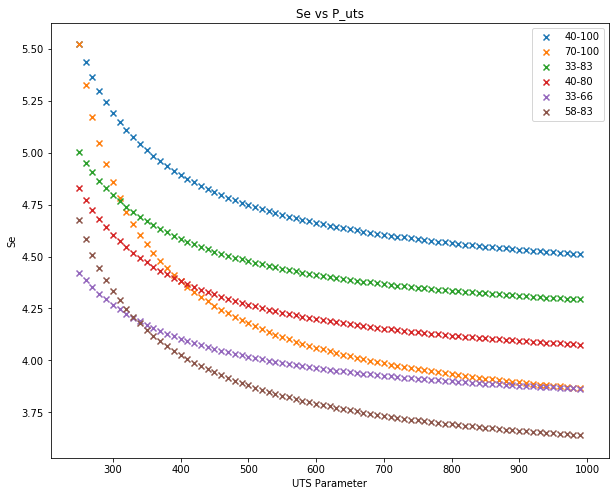

In [42]:
res_tab0 = pd.DataFrame(columns = ["UTS","40-100","70-100","33-83","40-80","33-66","58-83"])
Se_tab0 = pd.DataFrame(columns = ["UTS","40-100","70-100","33-83","40-80","33-66","58-83"])

a_ar = ([40, 70, 33, 40, 33.33, 58.33])
b_ar = ([100, 100, 83, 80, 66.66, 83.33])

#N  = [131300, 915400, 2403300, 8664200, 173210400,  37737400]

N = [878385,  6283754,  4261017, 10388584, 41440177, 43390730]

for i in range(250,1000,10):
    S_uts_est = i #49304.9319

    Se_arr = np.array([])

    for j in range(6):
        Se_temp = S_e(a_ar[j], b_ar[j], S_uts_est, S_100)
        Se_arr = np.append(Se_arr, Se_temp) 

    X_train = np.log(Se_arr.reshape(-1,1))
    Y_train = np.log(N)

    regressor = LinearRegression()  
    regressor.fit(X_train, Y_train) #training the algorithm
    interc = regressor.intercept_
    slop = regressor.coef_
    
    #print(m_est, -1*slop)
    #print(k_est, np.e**interc)
    
    Y_pred = regressor.predict(X_train)
    error = 100*(np.e**Y_pred/N - 1)

    res_tab0 = res_tab0.append( dict(zip(res_tab0.columns, np.append(S_uts_est,error))), ignore_index=True)
    Se_tab0 = Se_tab0.append( dict(zip(Se_tab0.columns, np.append(S_uts_est,Se_arr))), ignore_index=True)

### Error in life relative to Linear regression vs P_uts plots    
columns = res_tab0.columns
columns = np.delete(columns,0)

fig= plt.figure(figsize=(10,8))

for i in range(6):
    c = columns[i]
    plt.scatter(res_tab0['UTS'],res_tab0[c], marker = 'x', label = c)

plt.legend()
plt.xlabel('UTS')
plt.ylabel('percentage error')
plt.title("Error in life relative to Linear regression vs P_uts")
plt.axhline(y=10,color='k')
plt.axhline(y=-10,color='k')
plt.axhline(y=5,color='y')
plt.axhline(y=-5,color='y')
plt.show()

### Se vs P_uts plots
fig= plt.figure(figsize=(10,8))
columnse = Se_tab0.columns
columnse = np.delete(columnse,0)
for i in range(6):
    c = columnse[i]
    plt.scatter(Se_tab0['UTS'],np.log(Se_tab0[c]), marker = 'x', label = c)
plt.legend()
plt.xlabel('UTS Parameter')
plt.ylabel('Se')
plt.title("Se vs P_uts")
plt.show()